In [1]:
#Mouting drive for getting access to MyDrive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


##Importing required libraries

In [2]:
# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# ML Libraries
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Evaluation Metrics
#from yellowbrick.classifier import ClassificationReport
from sklearn import metrics

##Loading preprocesses data for the classification purpose.

In [3]:
crime = pd.read_pickle("drive/My Drive/Colab Notebooks/CMPE_255_Project/Chicago_Crime_Processed_Data.pkl")

In [4]:
crime.head()

,IUCR,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Month,Day_num,Time,day_of_week,primary_type_grouped,zone,Count_CrimeType_Column
0,0486,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,2015,41.815117,-87.670000,9,5,13,Saturday,NON-CRIMINAL_ASSAULT,South,1640154.0
1,0870,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,2015,41.895080,-87.765400,9,4,11,Friday,THEFT,North,2327482.0
3,2023,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,2015,41.937406,-87.716650,9,5,12,Saturday,NARCOTIC_OFFENSE,West,661033.0
4,0560,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,2015,41.881903,-87.755121,9,5,13,Saturday,NON-CRIMINAL_ASSAULT,North,1640154.0
5,0610,FORCIBLE ENTRY,RESIDENCE,False,False,614,6.0,21.0,71.0,05,2015,41.744379,-87.658431,9,5,10,Saturday,THEFT,South,2327482.0


In [5]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6626783 entries, 0 to 7311029
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   IUCR                    object 
 1   Description             object 
 2   Location Description    object 
 3   Arrest                  bool   
 4   Domestic                bool   
 5   Beat                    int64  
 6   District                float64
 7   Ward                    float64
 8   Community Area          float64
 9   FBI Code                object 
 10  Year                    int64  
 11  Latitude                float64
 12  Longitude               float64
 13  Month                   int64  
 14  Day_num                 int64  
 15  Time                    int64  
 16  day_of_week             object 
 17  primary_type_grouped    object 
 18  zone                    object 
 19  Count_CrimeType_Column  float64
dtypes: bool(2), float64(6), int64(5), object(7)
memory usage: 973.2+ MB


In [6]:
crime.isnull().sum().sum()

5348

In [7]:
crime.apply(lambda x: sum(x.isnull()),axis=0)

IUCR                         0
Description                  0
Location Description         0
Arrest                       0
Domestic                     0
Beat                         0
District                     0
Ward                         0
Community Area               0
FBI Code                     0
Year                         0
Latitude                     0
Longitude                    0
Month                        0
Day_num                      0
Time                         0
day_of_week                  0
primary_type_grouped      2674
zone                         0
Count_CrimeType_Column    2674
dtype: int64

In [8]:
crime['primary_type_grouped'].unique()

array(['NON-CRIMINAL_ASSAULT', 'THEFT', 'NARCOTIC_OFFENSE',
       'OTHER_OFFENSE', 'CRIMINAL_OFFENSE', 'WEAPONS_OFFENSE',
       'SEXUAL_OFFENSE', 'HUMAN_TRAFFICKING_OFFENSE', nan], dtype=object)

In [9]:
cime= crime.dropna(inplace=True)
crime = crime.reset_index(drop=True)

In [10]:
crime['primary_type_grouped'].unique()

array(['NON-CRIMINAL_ASSAULT', 'THEFT', 'NARCOTIC_OFFENSE',
       'OTHER_OFFENSE', 'CRIMINAL_OFFENSE', 'WEAPONS_OFFENSE',
       'SEXUAL_OFFENSE', 'HUMAN_TRAFFICKING_OFFENSE'], dtype=object)

In [11]:
crime.shape

(6624109, 20)

##Data processing further for applying random forest model.

In [12]:
# Convert Categorical Attributes to Numerical
for col_name in crime.columns:
    if(crime[col_name].dtype == 'object'):
        crime[col_name]= crime[col_name].astype('category')
        crime[col_name] = crime[col_name].cat.codes

In [13]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6624109 entries, 0 to 6624108
Data columns (total 20 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   IUCR                    int16  
 1   Description             int16  
 2   Location Description    int16  
 3   Arrest                  bool   
 4   Domestic                bool   
 5   Beat                    int64  
 6   District                float64
 7   Ward                    float64
 8   Community Area          float64
 9   FBI Code                int8   
 10  Year                    int64  
 11  Latitude                float64
 12  Longitude               float64
 13  Month                   int64  
 14  Day_num                 int64  
 15  Time                    int64  
 16  day_of_week             int8   
 17  primary_type_grouped    int8   
 18  zone                    int8   
 19  Count_CrimeType_Column  float64
dtypes: bool(2), float64(6), int16(3), int64(5), int8(4)
memory usage: 63

##To check correlation between different variables.

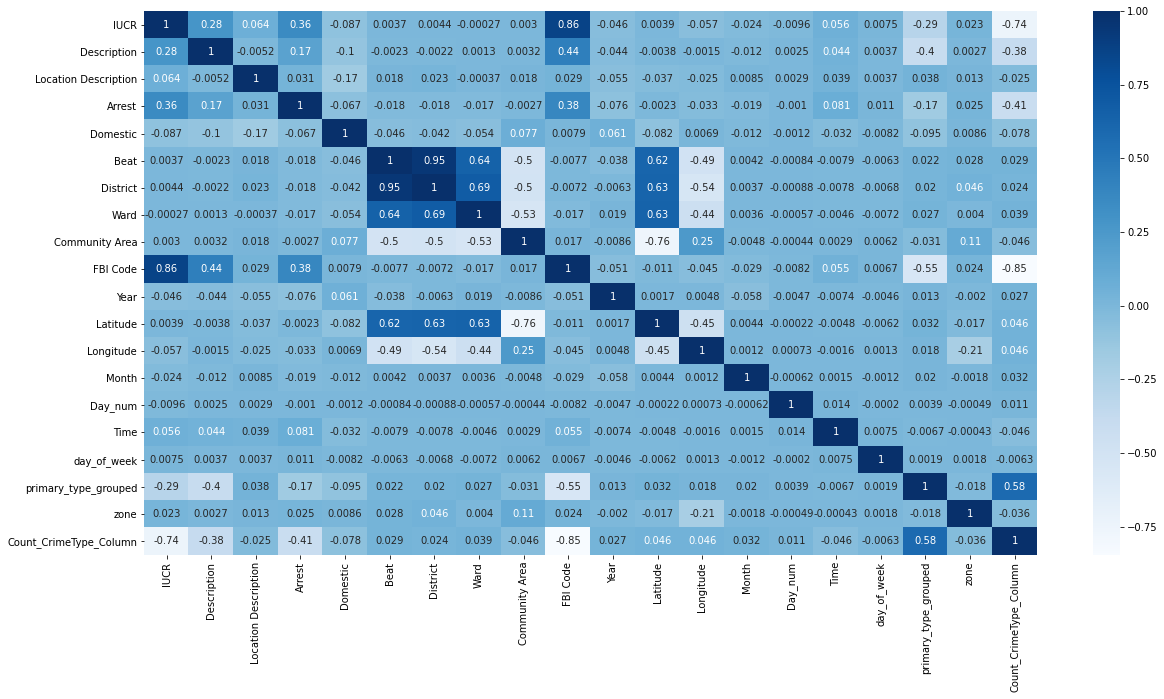

In [14]:
# Feature Selection using Filter Method 
# Split Dataframe to target class and features
X_fs = crime.drop(['primary_type_grouped'], axis=1)
Y_fs = crime['primary_type_grouped']

#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = crime.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [15]:
#Correlation with output variable
cor_target = abs(cor['primary_type_grouped'])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.25]
relevant_features

IUCR                      0.292668
Description               0.398370
FBI Code                  0.548101
primary_type_grouped      1.000000
Count_CrimeType_Column    0.582641
Name: primary_type_grouped, dtype: float64

##We can see that the three features are highly related with target crime type "primary_type_grouped" which is obvious as these are the attribuets which are updated after crime happened .Attributes like "FBI Code", "ICUR" and "Description".

In [16]:
# At Current Point, the attributes is select manually based on Feature Selection Part. 
#Features = ["IUCR", "Location Description", "FBI Code"]
Features = ["IUCR","Description","FBI Code"]
print('Full Features: ', Features)

Full Features:  ['IUCR', 'Description', 'FBI Code']


In [17]:
target ='primary_type_grouped'

## Splitting data in training and testing.

In [18]:
#Split dataset to Training Set & Test Set
x, y = train_test_split(crime, 
                        test_size = 0.2, 
                        train_size = 0.8, 
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Feature Set Used    :  ['IUCR', 'Description', 'FBI Code']
Target Class        :  primary_type_grouped
Training Set Size   :  (5299287, 20)
Test Set Size       :  (1324822, 20)


##Creating Random forest model.

In [19]:
# Random Forest
# Create Model with configuration
#rf_model = RandomForestClassifier()--------crashes the system

#rf_model = RandomForestClassifier(n_estimators=200, # Number of trees
#                                  min_samples_split = 30,
#                                  bootstrap = True, 
#                                  max_depth = 100, 
#                                  min_samples_leaf = 25)

rf_model = RandomForestClassifier(n_estimators=100, # Number of trees    -----------48 %
                                  min_samples_split = 30,
                                  bootstrap = True, 
                                  max_depth = 50, 
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=x1,y=x2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
y_pred_train = rf_model.predict(x1)

##Applying trained model to test data and getting predicted crime types.

In [21]:
#Feed the features of the test images to Random Forest Classifier to predict its class
y_pred_test= rf_model.predict(y1)

##Testing Accuracy for RF1 model.

In [22]:
#Testing accuracy
accuracy=accuracy_score(y_pred_test, y2)
print('Accuracy for testing data for RF model:', accuracy*100, '%.')

Accuracy for testing data for RF model: 99.99932066345517 %.


##Testing Accuracy is 99.99 %.

In [23]:
#target_names = Classes
target_names = ['CRIMINAL_OFFENSE','HUMAN_TRAFFICKING_OFFENSE','NARCOTIC_OFFENSE','NON_CRIMINAL_ASSAULT','OTHER_OFFENSE','SEXUAL_OFFENSE','THEFT','WEAPONS_OFFENSE']   

##Classification reports for Training and Testing.

In [24]:
# testing metrics
print("Testing metrics:")
print(classification_report(y_true= y2, y_pred= y_pred_test, target_names=target_names))

Testing metrics:
                           precision    recall  f1-score   support

         CRIMINAL_OFFENSE       1.00      1.00      1.00    245749
HUMAN_TRAFFICKING_OFFENSE       1.00      1.00      1.00     10293
         NARCOTIC_OFFENSE       1.00      1.00      1.00    132168
     NON_CRIMINAL_ASSAULT       1.00      1.00      1.00    328591
            OTHER_OFFENSE       1.00      1.00      1.00    102717
           SEXUAL_OFFENSE       1.00      1.00      1.00     22405
                    THEFT       1.00      1.00      1.00    466304
          WEAPONS_OFFENSE       1.00      1.00      1.00     16595

                 accuracy                           1.00   1324822
                macro avg       1.00      1.00      1.00   1324822
             weighted avg       1.00      1.00      1.00   1324822



In [25]:
# training metrics
print("Training metrics:")
print(classification_report(y_true=x2 , y_pred= y_pred_train, target_names=target_names))


Training metrics:
                           precision    recall  f1-score   support

         CRIMINAL_OFFENSE       1.00      1.00      1.00    985012
HUMAN_TRAFFICKING_OFFENSE       1.00      1.00      1.00     41153
         NARCOTIC_OFFENSE       1.00      1.00      1.00    528865
     NON_CRIMINAL_ASSAULT       1.00      1.00      1.00   1311563
            OTHER_OFFENSE       1.00      1.00      1.00    414371
           SEXUAL_OFFENSE       1.00      1.00      1.00     90490
                    THEFT       1.00      1.00      1.00   1861178
          WEAPONS_OFFENSE       1.00      1.00      1.00     66655

                 accuracy                           1.00   5299287
                macro avg       1.00      1.00      1.00   5299287
             weighted avg       1.00      1.00      1.00   5299287



##Confusion matrix for testing data.

In [26]:
# Visualise classical Confusion M0atrix
CM = confusion_matrix(y2, y_pred_test)
print(CM)

[[245749      0      0      0      0      0      0      0]
 [     0  10291      0      0      2      0      0      0]
 [     0      0 132168      0      0      0      0      0]
 [     0      0      0 328587      3      0      0      1]
 [     0      3      0      0 102714      0      0      0]
 [     0      0      0      0      0  22405      0      0]
 [     0      0      0      0      0      0 466304      0]
 [     0      0      0      0      0      0      0  16595]]


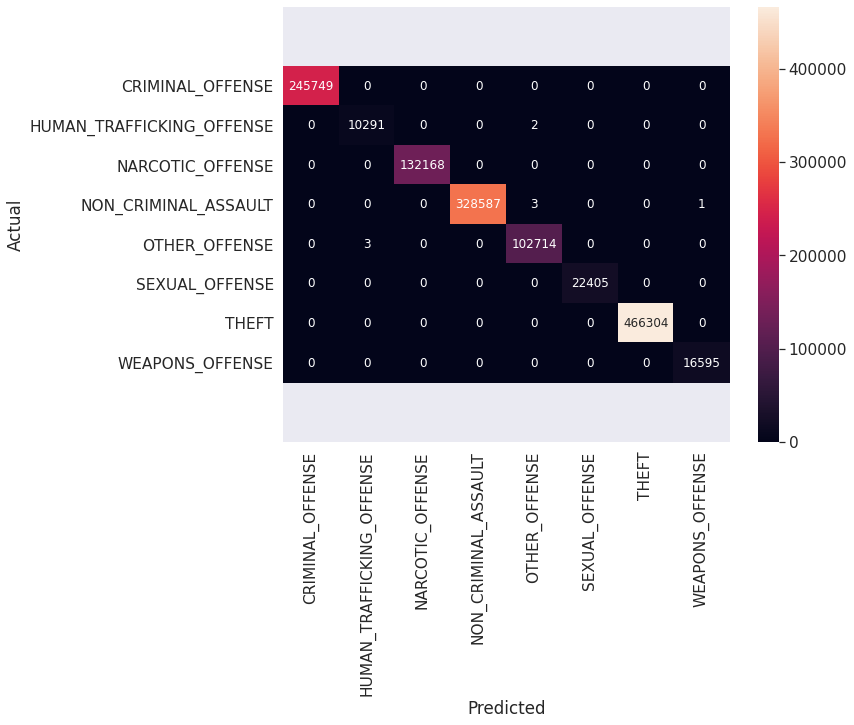

In [27]:
# Visualize it as a heatmap
#cmap="YlGnBu"
sns.set(font_scale=1.4) # for label size
ax = plt.subplots(figsize=(10, 8))
ax=sns.heatmap(CM,annot=True,annot_kws={"size": 12},fmt='d',xticklabels=target_names, yticklabels=target_names,cmap="blues")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 1.5, top - 1.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

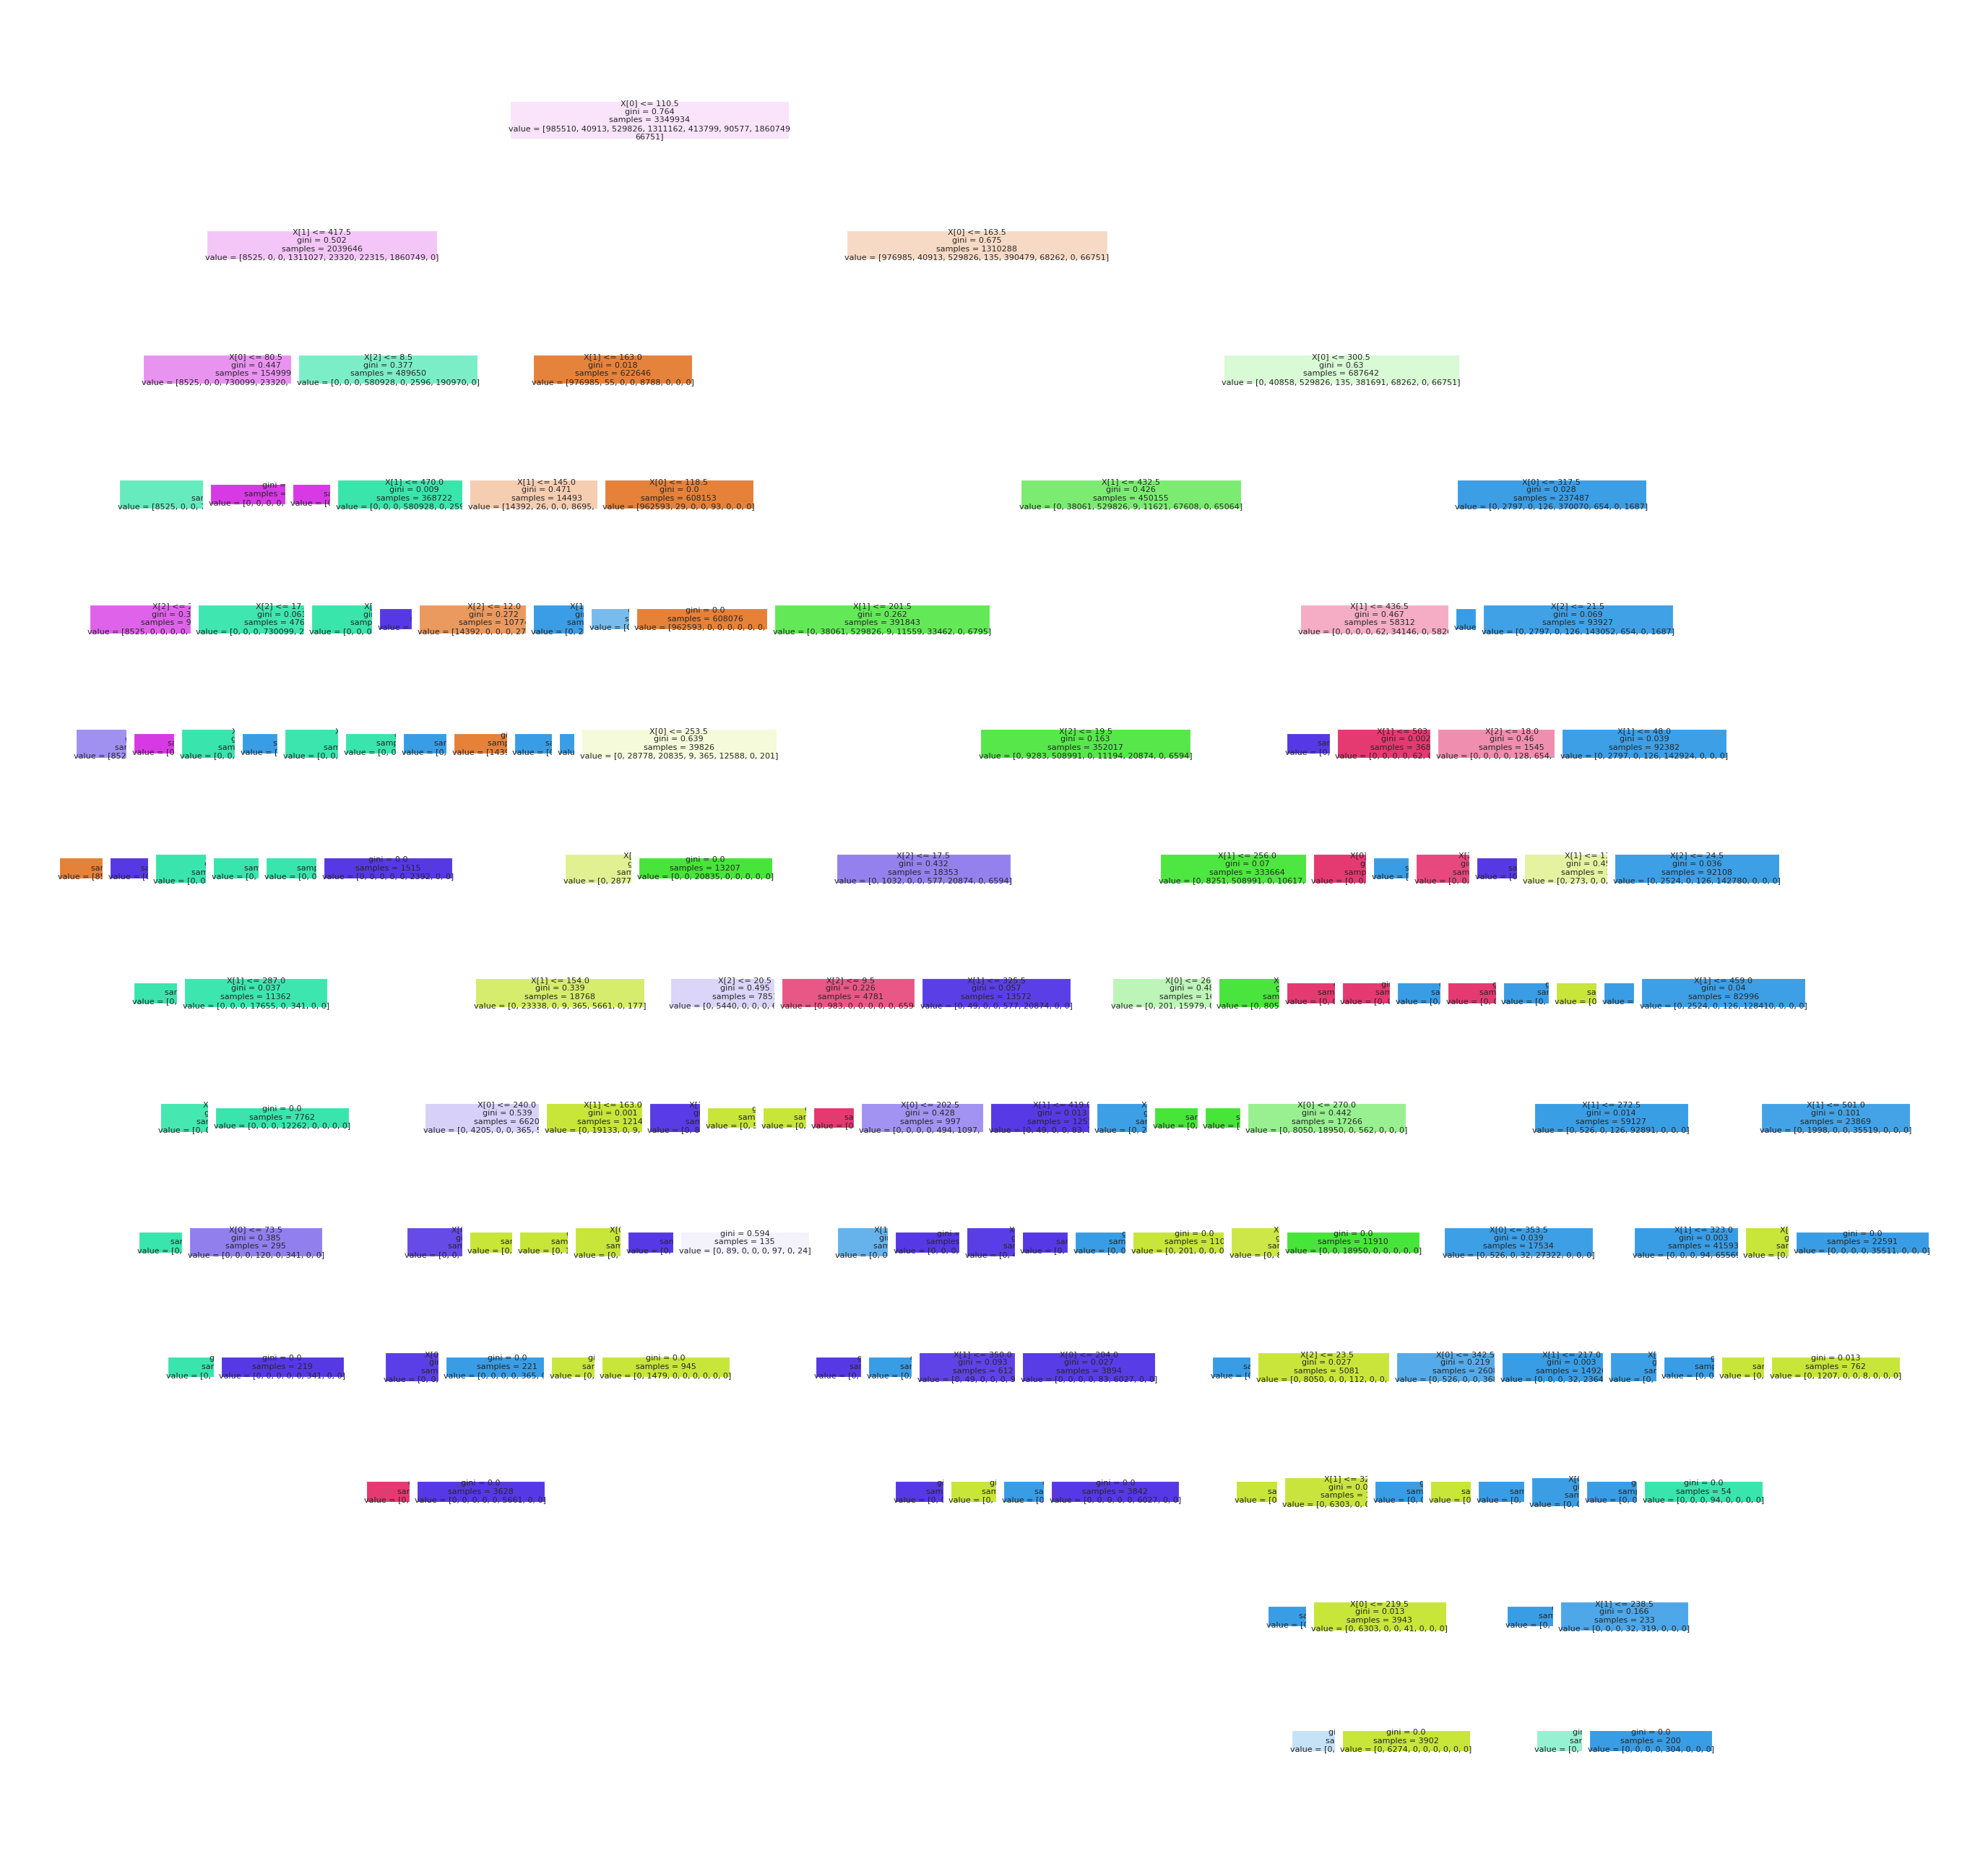

In [49]:
from sklearn import tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf_model.estimators_[0],
               filled = True);

##Creating small sample_data for the evaluation of model.

In [ ]:
y.shape

(1324822, 20)

In [ ]:
sample_data = y.sample(n = 500)

In [ ]:
sample_data.head()

,IUCR,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,Year,Latitude,Longitude,Month,Day_num,Time,day_of_week,primary_type_grouped,zone,Count_CrimeType_Column
6230038,3,66,17,True,False,312,3.0,20.0,42.0,2,2018,41.777697,-87.613148,5,13,14,3,5,2,112895.0
6566590,95,348,139,False,False,212,2.0,4.0,35.0,7,2015,41.830697,-87.614477,3,2,21,1,6,2,2327482.0
2835911,307,444,158,False,False,1412,14.0,35.0,21.0,25,2006,41.939225,-87.716621,3,14,2,5,4,3,517088.0
5171670,61,66,181,True,False,1013,10.0,22.0,30.0,4,2011,41.844699,-87.727806,12,11,1,3,3,2,1640154.0
3509131,85,340,147,False,False,1811,18.0,32.0,7.0,7,2007,41.921606,-87.665477,7,26,11,4,6,3,2327482.0


In [ ]:
sample_data.shape

(500, 20)

In [ ]:
import os
print(os.listdir(r"drive/My Drive/Colab Notebooks/CMPE_255_Project"))

['Chicago_Crime', 'Chicago_Crime_Processed_Data.pkl']


In [ ]:
# storing pandas dataframe as a picklefile for later use ...(Merged dataset for three files review, user, business)
os.path.isfile("drive/My Drive/Colab Notebooks/CMPE_255_Project/Sample_Data.pkl")
sample_data.to_pickle("drive/My Drive/Colab Notebooks/CMPE_255_Project/Sample_Data.pkl")

##Saving this RF1 model for using with sample data directly.

In [ ]:
import joblib

In [ ]:
# save
joblib.dump(rf_model, "drive/My Drive/Colab Notebooks/CMPE_255_Project/RF1.joblib")

['drive/My Drive/Colab Notebooks/CMPE_255_Project/RF1.joblib']

##Testing RF1 model on sample data and to check whether sample data and model is saved correctly.

In [ ]:
loaded_rf = joblib.load("drive/My Drive/Colab Notebooks/CMPE_255_Project/RF1.joblib")

In [ ]:
s_y1 = sample_data[Features]    #Features to test
s_y2 = sample_data[target]      #Target Class to test

In [ ]:
sample_y2= loaded_rf.predict(s_y1)

In [ ]:
#Testing accuracy
sample_accuracy=accuracy_score(sample_y2, s_y2)
print('Accuracy for testing data for RF model on sample data:', sample_accuracy*100, '%.')

Accuracy for testing data for RF model on sample data: 100.0 %.
